# EOD Price History Prediction
*This notebook is intended to predict price movements based on EOD closing prices. Work in progress.*

This notebook is largely based on code from this article:
https://towardsdatascience.com/multiple-stock-prediction-using-deep-learning-network-d19a7acd8551`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

# The cells below here only read symbols from the notebook that are similar to the one that we are trying to predict, given the the amount of data we have.

## For now, run the first import cell in the notebook, then work from here.

*In the example below, we're only going to look at stocks that have the same sector or industry id as FСEL*

In [2]:
conn = sqlite3.connect('stockPrediction_05262021.db')

query = "SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM eod_price_history l INNER JOIN stock r ON r.stock_id = l.stock_id WHERE r.sector_id = 13 OR r.industry_id = 17;"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])
df

open_price  high_price  low_price  close_price  \
stock_symbol price_datetime                                                   
PLUG         1999-10-29        157.5000    196.8750  150.00000      160.000   
             1999-11-01        167.5000    167.5000  150.00000      160.000   
             1999-11-02        164.3750    200.0000  163.75000      178.750   
             1999-11-03        188.7500    193.1250  181.25000      186.250   
             1999-11-04        194.3750    198.7500  186.25000      190.625   
...                                 ...         ...        ...          ...   
WLMS         2021-05-26          4.9800      4.9700    4.85000        4.930   
WTNW         2021-05-26          0.0200      0.0200    0.01971        0.020   
BUKS         2021-05-26          0.5801      0.5865    0.58000        0.580   
EAWD         2021-05-26          0.3322      0.3322    0.30525        0.310   
EFSH         2021-05-26          2.1200      2.1200    2.12000        2.120   

                               volume  dividends stock_splits  
stock_symbol price_datetime                                    
PLUG         1999-10-29      542660.0        0.0          0.0  
             1999-11-01      150600.0        0.0          0.0  
             1999-11-02      170110.0        0.0          0.0  
             1999-11-03       68310.0        0.0          0.0  
             1999-11-04       48000.0        0.0          0.0  
...                               ...        ...          ...  
WLMS         2021-05-26       37512.0        0.0            0  
WTNW         2021-05-26       69018.0        0.0            0  
BUKS         2021-05-26        3000.0        0.0            0  
EAWD         2021-05-26       49751.0        0.0            0  
EFSH         2021-05-26         300.0        0.0          0.0  

[596423 rows x 7 columns]

*Now, lets remove the index and reshape the data to prepare it for our model. In doing so, we're also going to convert the price_datetime column to datetime/timestamp objects prior to resetting our index.*

In [3]:
# reset the index
df = df.reset_index()

In [4]:
# convert to datetime
df['price_datetime'] = pd.to_datetime(df['price_datetime'], format='%Y-%m-%d')

In [5]:
# check to make sure the data type is write
type(df['price_datetime'][0])

pandas._libs.tslibs.timestamps.Timestamp

*Next, we will reshape our data. We will make the price_datetime the index, and add columns for each symbol. After this, we can filter the dataframe based on date range.*

In [6]:
# reshape
df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])

In [7]:
df

open_price                                                    \
stock_symbol         ACTG  AEHL  AENZ   AERG   AFI  AIRI  ALJJ   AMMJ  APWC   
price_datetime                                                                
1973-02-21            NaN   NaN   NaN    NaN   NaN   NaN   NaN    NaN   NaN   
1973-02-22            NaN   NaN   NaN    NaN   NaN   NaN   NaN    NaN   NaN   
1973-02-23            NaN   NaN   NaN    NaN   NaN   NaN   NaN    NaN   NaN   
1973-02-26            NaN   NaN   NaN    NaN   NaN   NaN   NaN    NaN   NaN   
1973-02-27            NaN   NaN   NaN    NaN   NaN   NaN   NaN    NaN   NaN   
...                   ...   ...   ...    ...   ...   ...   ...    ...   ...   
2021-05-20           5.59  2.55  1.53  0.690  6.33  1.24  1.38  0.207  3.38   
2021-05-21           5.64  2.59  1.52  0.720  6.23  1.22  1.41  0.192  3.34   
2021-05-24           5.53  2.68  1.58  0.793  6.48  1.25  1.44  0.195  3.63   
2021-05-25           5.60  2.65  1.61  0.769  6.34  1.20  1.43  0.190  3.75   
2021-05-26           5.60  2.57  1.57  0.740  6.04  1.20  1.43  0.200  3.58   

                      ... stock_splits                                     \
stock_symbol    AQMS  ...         VIVC VOLT VOYT VRME VTSI WARM WHLM WLMS   
price_datetime        ...                                                   
1973-02-21       NaN  ...          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1973-02-22       NaN  ...          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1973-02-23       NaN  ...          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1973-02-26       NaN  ...          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1973-02-27       NaN  ...          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...              ...  ...          ...  ...  ...  ...  ...  ...  ...  ...   
2021-05-20      2.63  ...          0.0  0.0    0  0.0  0.0  0.0  0.0    0   
2021-05-21      2.59  ...          0.0  0.0    0  0.0  0.0  0.0  0.0    0   
2021-05-24      2.50  ...          0.0  0.0    0  0.0  0.0  0.0  0.0    0   
2021-05-25      2.48  ...          0.0  0.0    0  0.0  0.0  0.0  0.0    0   
2021-05-26      2.47  ...          NaN  0.0  NaN  0.0  0.0  0.0  0.0    0   

                          
stock_symbol   WSCO WTNW  
price_datetime            
1973-02-21      NaN  NaN  
1973-02-22      NaN  NaN  
1973-02-23      NaN  NaN  
1973-02-26      NaN  NaN  
1973-02-27      NaN  NaN  
...             ...  ...  
2021-05-20      0.0    0  
2021-05-21      0.0    0  
2021-05-24      0.0    0  
2021-05-25      0.0    0  
2021-05-26      NaN    0  

[12176 rows x 1120 columns]

In [8]:
df = df.loc['2019-01-01':'2021-05-31']  # date range from 2019-01-01 to 2021-05-31

In [9]:
df['close_price']

stock_symbol,ACTG,AEHL,AENZ,AERG,AFI,AIRI,ALJJ,AMMJ,APWC,AQMS,...,VIVC,VOLT,VOYT,VRME,VTSI,WARM,WHLM,WLMS,WSCO,WTNW
price_datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-02,3.10,5.670,2.96,NaN,12.54,0.7900,1.38,0.33000,1.79,1.85,...,0.5000,2.29,0.0004,10.975,3.60,0.03500,5.83,2.34,0.1201,0.37000
2019-01-03,3.00,4.140,2.91,NaN,12.62,0.7900,1.33,0.37000,1.95,1.81,...,0.5000,2.44,0.0004,13.000,3.32,0.03290,5.83,2.34,0.1201,0.38900
2019-01-04,2.99,4.920,2.75,NaN,13.34,0.7900,1.35,0.38200,1.96,1.88,...,0.6375,2.58,0.0004,14.000,3.17,0.03000,5.83,2.32,0.1201,0.38900
2019-01-07,3.07,4.740,2.82,NaN,13.41,0.8700,1.41,0.41300,1.95,1.90,...,0.7125,2.78,0.0004,12.500,3.64,0.03480,5.83,2.38,0.1201,0.38000
2019-01-08,3.14,4.560,2.90,NaN,13.42,0.9500,1.45,0.48000,1.95,1.82,...,0.8125,2.85,0.0004,12.500,3.64,0.03240,5.76,2.40,0.1201,0.49100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-20,5.58,2.580,1.61,0.777,6.20,1.2300,1.39,0.19300,3.37,2.58,...,2.1000,3.89,0.0004,3.320,5.69,0.05600,4.86,4.69,0.1100,0.02290
2021-05-21,5.51,2.690,1.56,0.792,6.42,1.2200,1.42,0.18300,3.55,2.52,...,2.1000,3.89,0.0004,3.370,5.73,0.05965,4.94,4.87,0.3000,0.02000
2021-05-24,5.60,2.680,1.66,0.769,6.38,1.2000,1.43,0.18900,3.67,2.48,...,2.1000,3.90,0.0002,3.380,5.65,0.05050,4.90,5.07,0.3000,0.02050


In [10]:
# set a threshold of how many np.nan you are willing to work with
close_df = df['close_price'].dropna(thresh=(len(df['close_price'] / 0.2)), axis=1)

In [11]:
# forward fill in np.nan values in columns not previously dropped.
close_df = close_df.fillna(method='ffill', axis=1)

<AxesSubplot:xlabel='price_datetime'>

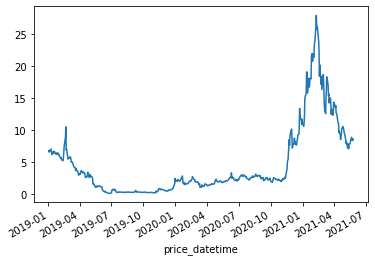

In [12]:
close_df['FCEL'].plot()

## Creating a ML model

### Split the test/training data

In [56]:
# Choose what Symbol you would like to predict:
symbol = 'PLUG'     # change to whatever symbol in your dataframe you'd like to attempt to predict.

In [57]:
# splitting test/training data

# close_df = close_df.reset_index()

data_size = len(close_df)

# using a 90/10 train/test split
training_data = close_df.iloc[:(int(data_size * .9))]
test_data = close_df.iloc[(int(data_size * .9)):]

In [13]:
training_data

stock_symbol,ACTG,AEHL,AENZ,AFI,AIRI,ALJJ,AMMJ,APWC,AQMS,ARC,...,TPCS,TWI,USDP,VOLT,VRME,VTSI,WARM,WHLM,WLMS,WTNW
price_datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-02,3.10,5.67,2.96,12.54,0.79,1.38,0.330,1.79,1.850,2.161965,...,0.98,4.771490,7.658818,2.29,10.975,3.60,0.0350,5.83,2.34,0.37000
2019-01-03,3.00,4.14,2.91,12.62,0.79,1.33,0.370,1.95,1.810,2.287436,...,0.98,4.702050,7.709780,2.44,13.000,3.32,0.0329,5.83,2.34,0.38900
2019-01-04,2.99,4.92,2.75,13.34,0.79,1.35,0.382,1.96,1.880,2.615592,...,0.97,5.148448,7.644256,2.58,14.000,3.17,0.0300,5.83,2.32,0.38900
2019-01-07,3.07,4.74,2.82,13.41,0.87,1.41,0.413,1.95,1.900,2.692805,...,0.97,5.872603,7.760740,2.78,12.500,3.64,0.0348,5.83,2.38,0.38000
2019-01-08,3.14,4.56,2.90,13.42,0.95,1.45,0.480,1.95,1.820,2.692805,...,0.97,5.842843,7.724339,2.85,12.500,3.64,0.0324,5.76,2.40,0.49100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,3.77,2.19,2.20,3.49,1.27,1.09,0.089,2.37,1.150,1.302080,...,1.30,5.450000,3.458619,1.80,3.070,4.08,0.0205,3.78,1.75,0.03880
2020-11-25,3.78,2.37,2.17,3.56,1.26,1.07,0.086,2.43,1.265,1.361265,...,1.30,5.260000,3.650765,2.11,3.000,4.00,0.0194,3.75,1.77,0.03840
2020-11-27,3.70,2.36,2.27,3.80,1.27,1.07,0.085,2.30,1.240,1.380994,...,1.27,5.200000,3.823696,2.17,3.390,4.02,0.0176,3.80,1.77,0.03556


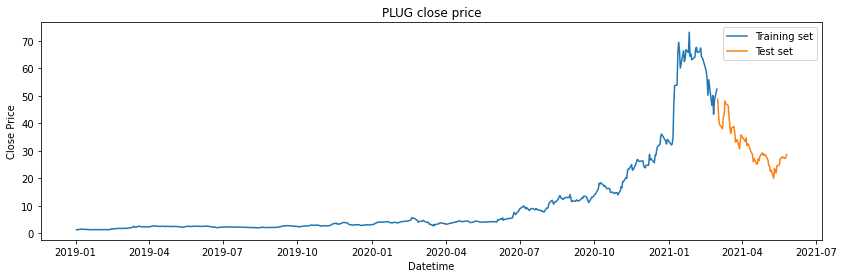

In [58]:
# visualize train/test dataset to ensure it is accurate
plt.figure(figsize=(14,4))
plt.plot(training_data[symbol])
plt.plot(test_data[symbol])
plt.ylabel('Close Price')
plt.xlabel('Datetime')
plt.legend(["Training set", "Test set"])
plt.title(f"{symbol} close price")
plt.show()

In [15]:
training_data.isna().sum().sum()

0

## Normalization

*Using MinMaxScaler, normalize data on a 0-1 scale using the training data.*
*The minmax_single symbol will be the one we are trying to predict. In this case, the one we are trying to predict is FCEL*

In [59]:
# First, create a singular dataframe from the symbol you would like to predict vaues for
training_data_predicted = training_data[symbol]
training_data_predicted = training_data_predicted.to_frame()
training_data_predicted

,PLUG
price_datetime,
2019-01-02,1.330000
2019-01-03,1.260000
2019-01-04,1.340000
2019-01-07,1.530000
2019-01-08,1.600000
...,...
2021-02-23,46.580002
2021-02-24,50.160000
2021-02-25,43.340000


In [60]:
minmax = MinMaxScaler(feature_range=(0,1))
minmax_single = MinMaxScaler(feature_range=(0,1))

# Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
training_data = training_data.drop(columns=symbol)
train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

columns = [i for i in training_data.columns]
columns.append(symbol)

# I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
training_data[symbol] = training_data_predicted[symbol]

train_scaled = pd.DataFrame(train_scaled, columns=columns)
train_scaled

,ACTG,AEHL,AENZ,AFI,AIRI,ALJJ,AMMJ,APWC,AQMS,ARC,...,TWI,USDP,VOLT,VRME,VTSI,WARM,WHLM,WLMS,WTNW,PLUG
0,0.167951,0.895028,0.652893,0.818645,0.072398,0.622093,0.518519,0.132018,0.219477,0.758359,...,0.489532,0.794200,0.372685,0.6780,0.401914,0.462990,0.638532,0.483986,0.363360,0.000973
1,0.152542,0.613260,0.632231,0.824472,0.072398,0.593023,0.592593,0.156297,0.213663,0.815474,...,0.480273,0.800726,0.407407,0.8400,0.327485,0.432511,0.638532,0.483986,0.382591,0.000000
2,0.151002,0.756906,0.566116,0.876912,0.072398,0.604651,0.614815,0.157815,0.223837,0.964852,...,0.539793,0.792335,0.439815,0.9200,0.287613,0.390421,0.638532,0.476868,0.382591,0.001112
3,0.163328,0.723757,0.595041,0.882010,0.108597,0.639535,0.672222,0.156297,0.226744,1.000000,...,0.636347,0.807253,0.486111,0.8000,0.412547,0.460087,0.638532,0.498221,0.373482,0.003754
4,0.174114,0.690608,0.628099,0.882739,0.144796,0.662791,0.796296,0.156297,0.215116,1.000000,...,0.632379,0.802591,0.502315,0.8000,0.412547,0.425254,0.625688,0.505338,0.485830,0.004727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,0.942989,0.578269,0.380165,0.188638,0.452489,0.668605,0.500000,0.667678,0.651163,0.861600,...,0.988000,0.441192,0.532407,0.1520,0.893674,0.409289,0.634862,0.715303,0.028340,0.630145
540,0.893683,0.556169,0.363636,0.202476,0.484163,0.802326,0.548148,0.732929,0.774709,0.784897,...,1.000000,0.453749,0.564815,0.1744,0.893674,0.477504,0.706422,0.750890,0.024291,0.679922
541,0.855162,0.480663,0.363636,0.199563,0.411765,0.697674,0.518519,0.702580,0.674419,0.757826,...,0.946667,0.439936,0.495370,0.1480,0.933546,0.444122,0.788991,0.733096,0.028340,0.585095
542,0.784283,0.440147,0.363636,0.282593,0.411765,0.674419,0.514815,0.682853,0.639535,0.726242,...,0.956000,0.422357,0.486111,0.1536,0.960128,0.477504,0.768807,0.864413,0.024848,0.655172


## Shaping data for LSTM

In [61]:
train_scaled = train_scaled.values
n_lags = int(60) # not sure why hard 60
X_train = []
y_train = []
for i in range(n_lags, train_scaled.shape[0]):
    X_train.append(train_scaled[i-n_lags:i])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

In [51]:
# check shapes
X_train.shape, y_train.shape

((484, 60, 142), (484,))

## Build the LSTM network
*I think for now that I may only try to do a single layer, to speed up development of the project.*

**Be sure that the last layer of the network has return_sequences set to False.**

In [40]:
# LSTM architecture
regressor = tf.keras.Sequential()

# First layer, w/ dropout regularization
regressor.add(tf.keras.layers.LSTM(units=20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(tf.keras.layers.Dropout(0.2))

# Second
regressor.add(tf.keras.layers.LSTM(units=20))
regressor.add(tf.keras.layers.Dropout(0.5))

# Output layer
regressor.add(tf.keras.layers.Dense(units=1))

# Compile LSTM
regressor.compile(optimizer='adam', loss='mean_squared_error')

# Fit to Training set
# fit to training set
num_features = len(training_data.columns)
progress = 1
for i in training_data.columns:
    print("Fitting to", i)
    print("Training feature", progress, "of", num_features)
    regressor.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
    progress += 1

Fitting to ACTG
Training feature 1 of 142
Fitting to AEHL
Training feature 2 of 142
Fitting to AENZ
Training feature 3 of 142
Fitting to AFI
Training feature 4 of 142
Fitting to AIRI
Training feature 5 of 142
Fitting to ALJJ
Training feature 6 of 142
Fitting to AMMJ
Training feature 7 of 142
Fitting to APWC
Training feature 8 of 142
Fitting to AQMS
Training feature 9 of 142
Fitting to ARC
Training feature 10 of 142
Fitting to ARTW
Training feature 11 of 142
Fitting to ASC
Training feature 12 of 142
Fitting to ASDN
Training feature 13 of 142
Fitting to ASTC
Training feature 14 of 142
Fitting to AWX
Training feature 15 of 142
Fitting to BBCP
Training feature 16 of 142
Fitting to BDRAF
Training feature 17 of 142
Fitting to BDRBF
Training feature 18 of 142
Fitting to BEST
Training feature 19 of 142
Fitting to BHTG
Training feature 20 of 142
Fitting to BKYI
Training feature 21 of 142
Fitting to BNET
Training feature 22 of 142
Fitting to BUKS
Training feature 23 of 142
Fitting to BW
Training

In [ ]:
# set a model name and save it
# cell is optional
regressor.save('model_05202021')

## Predictions
*1. Merge training/testing set on 0 axis.
2. Set the n_lags as time steps.
3. Transform the new data set.
4. Reshape the new data set.*

In [62]:
total_data = pd.concat((training_data, test_data), axis=0)
inputs = total_data[len(total_data) - len(test_data) - 60:]
# inputs = data[len(data) - len(test_data) - 60:]

predicted_input = inputs[symbol].to_frame()
inputs = inputs.drop(columns=symbol)

test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
print('Shape of test data:', test_scaled.shape)

# shaping test data from neural network
X_test = []
y_test = []
for i in range(60, test_scaled.shape[0]):
    X_test.append(test_scaled[i-n_lags:i])
    y_test.append(test_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

Shape of test data: (121, 142)


In [63]:
predicted_price = regressor.predict(X_test)
predicted_price = minmax_single.inverse_transform(predicted_price)
predicted_price = pd.DataFrame(predicted_price)
predicted_price.rename(columns = {0: f'{symbol}_predicted'}, inplace=True)
predicted_price = predicted_price.round(decimals=2)
predicted_price.index = test_data.index

In [64]:
predicted_price[f'{symbol}_predicted']

price_datetime
2021-03-02    64.690002
2021-03-03    64.970001
2021-03-04    65.220001
2021-03-05    62.740002
2021-03-08    61.060001
                ...    
2021-05-20    45.770000
2021-05-21    44.459999
2021-05-24    44.720001
2021-05-25    43.169998
2021-05-26    41.099998
Name: PLUG_predicted, Length: 61, dtype: float32

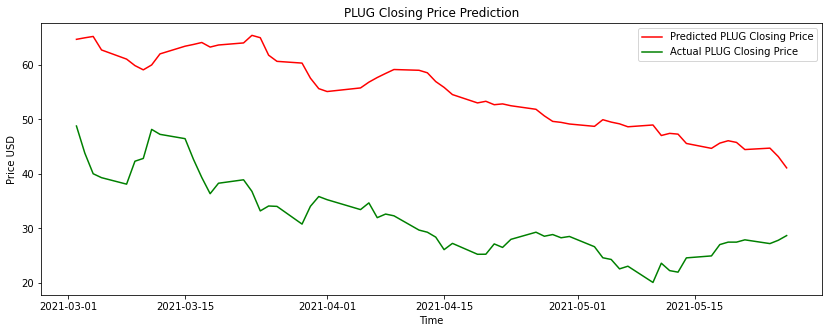

In [65]:
# Visualization
from sklearn.metrics import mean_squared_error
plt.figure(figsize=(14,5))
#mse = mean_squared_error(y_test, predicted_price)
plt.plot(predicted_price[f'{symbol}_predicted'], color = 'red', label= f'Predicted {symbol} Closing Price')
plt.plot(test_data[symbol], color = 'green', label = f'Actual {symbol} Closing Price')
# plt.title("FCEL Closing PRice Prediction w/ MSE {:10:4f}".format(mse))
plt.title(f'{symbol} Closing Price Prediction')
plt.xlabel("Time")
plt.ylabel('Price USD')
plt.legend()